# affine invariant ensemble sampler + AIS

### 12D transporter model (single antiporter cycle)

Annealed Importance Sampling w/ the Affine Invariant Sampler

1. Initialization
    1. set $\mathrm{ESS_{min}}$, $\beta=0$, $\Delta\beta$, $N$ steps, $K$ walkers, last fraction of samples to keep $\alpha$ 
        1. note: choose small $\Delta\beta$ 
        2. note: choose  $(\alpha \cdot N\cdot K)$>>$K$
        3. note: need to let samples become 'decorrelated' $\rightarrow$ select some fraction of samples at the end
    2. generate $\alpha \cdot N\cdot K$ initial samples from a Uniform distribution (same as priors)
    3. calculate likelihoods at initial sample points ($\beta$=0), $\mathcal{L_{0}}$
2. Determine new $\beta$ 
    1. WHILE $\mathrm{ESS}$ > $\mathrm{ESS_{min}}$:
        1. increment $\beta$:  $\beta_{\mathrm{new}} \rightarrow \beta + \Delta\beta$
        2. calculate $\mathrm{ESS}$:
            1. calculate weights $w$: $w(x) = \mathcal{L}^{(\beta_{\mathrm{new}}-\beta)}$
                1. note: using log likelihood, so use relative weights:
                    1. $\ln(w) = (\beta_{\mathrm{new}}-\beta) \ln(\mathcal{L_{\mathrm{ref}}})$
                    2. $\ln(w)_{\mathrm{rel}} = \ln(w)_{\mathrm{i}} - \max{\ln(w)}$ 
            2. calculate $\mathrm{ESS}$:
                1. $\mathrm{ESS} = \sum{\frac{w_i}{\max{w}}} = \sum(\exp(\ln(w)_{\mathrm{rel}}))$
3. Run sampler
    1. resample $K$ walkers, drawn with replacement from initial parameter set distribution using weights, $w$.
    2. run (affine invarient ensemble) sampler for $N\cdot K$ total samples
    3. select the last fraction of samples to keep $\alpha \cdot N\cdot K$ 
    4. calculate likelihood for the above samples
4. repeat 2-3 until $\beta=1$
    1. (possibly run sampler longer when $\beta=1$)


21482.241158539688


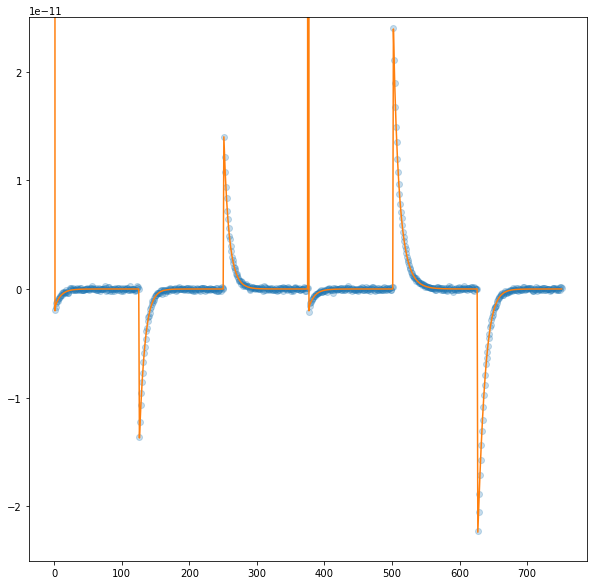

In [67]:
import numpy as np, tellurium as te, matplotlib.pyplot as plt
import emcee as mc, corner, time, pandas as pd
np.random.seed(10)


# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


antimony_string = f"""
            // Created by libAntimony v2.12.0
            model transporter_full()

            // Compartments and Species:
            compartment vol;
            species OF in vol, OF_Hb in vol;
            species IF_Hb in vol, IF_Hb_Sb in vol;
            species IF_Sb in vol, OF_Sb in vol;
            species H_in in vol, S_in in vol;
            species $H_out in vol, $S_out in vol;

            // Reactions:
            rxn1: OF + $H_out -> OF_Hb; vol*(k1_f*OF*H_out - k1_r*OF_Hb);
            rxn2: OF_Hb -> IF_Hb; vol*(k2_f*OF_Hb - k2_r*IF_Hb);
            rxn3: IF_Hb + S_in -> IF_Hb_Sb; vol*(k3_f*IF_Hb*S_in - k3_r*IF_Hb_Sb);
            rxn4: IF_Hb_Sb -> IF_Sb + H_in; vol*(k4_f*IF_Hb_Sb - k4_r*IF_Sb*H_in);
            rxn5: IF_Sb -> OF_Sb; vol*(k5_f*IF_Sb - k5_r*OF_Sb);
            rxn6: OF_Sb -> OF + $S_out; vol*(k6_f*OF_Sb - k6_r*OF*S_out);
            

            // Events:
            E1: at (time >= 5): H_out = H_out_activation, S_out = S_out_activation;
            E2: at (time >= 10): H_out = 1e-7, S_out = 0.001;

            // Species initializations:
            H_out = 1e-07;
            H_out has substance_per_volume;

            H_in = 1e-7;
            H_in has substance_per_volume;

            S_out = 0.001;
            S_out has substance_per_volume;

            S_in = 1e-3;
            S_in has substance_per_volume;

            OF = 2.833e-8;
            OF has substance_per_volume;

            OF_Hb = 2.833e-8;
            OF_Hb has substance_per_volume;

            IF_Hb = 2.833e-8;
            IF_Hb has substance_per_volume;
            
            IF_Hb_Sb = 2.833e-8;
            IF_Hb_Sb has substance_per_volume;
            
            IF_Sb = 2.125e-08;
            IF_Sb has substance_per_volume;

            OF_Sb = 2.125e-08;
            OF_Sb has substance_per_volume;


            // Compartment initializations:
            vol = 0.0001;
            vol has volume;

            // Variable initializations:
            H_out_activation = 5e-8;
            S_out_activation = 0.001;

            // Rate constant initializations:
            k1_f = 1e10;
            k1_r = 1e3;
            k2_f = 1e2;
            k2_r = 1e2;
            k3_f = 1e7;
            k3_r = 1e3;
            k4_f = 1e3;
            k4_r = 1e10;
            k5_f = 1e2;
            k5_r = 1e2;
            k6_f = 1e3;
            k6_r = 1e7;


            // Other declarations:
            const vol;
            const k1_f, k1_r, k2_f, k2_r, k3_f, k3_r;
            const k4_f, k4_r, k5_f, k5_r, k6_f, k6_r;
    

            // Unit definitions:
            unit substance_per_volume = mole / litre;
            unit volume = litre;
            unit length = metre;
            unit area = metre^2;
            unit time_unit = second;
            unit substance = mole;
            unit extent = mole;

            // Display Names:
            time_unit is "time";
            end
            """ 


m = te.loada(antimony_string)
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12

D = m.simulate(0, 15, 376, selections=['time', 'rxn4'])
#y_true = D['rxn4']

m.resetToOrigin()
m.H_out_activation = 2e-7
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12
D2 = m.simulate(0, 15, 376, selections=['time', 'rxn4'])

y_true = np.hstack([D['rxn4'],D2['rxn4']])

noise_stdev_true = 1e-13
y_obs = y_true + np.random.normal(0, noise_stdev_true, len(y_true))
#y_obs = np.genfromtxt("data_grid_test3.csv", skip_header=1)

plt.figure(figsize=(10,10))
plt.plot(y_obs, 'o', alpha=0.25)
plt.plot(y_true)
plt.ylim(-2.5e-11, 2.5e-11)

log_like_ref = calc_norm_log_likelihood(y_true,noise_stdev_true,y_obs)

print(log_like_ref)

In [47]:
# Algorithm outline: 

### Functions

# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


# simulate model and then compare flux data to observed data
def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    sigma = 10**theta[0]
    K=theta[1:]
    m = extra_parameters[0] 
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k2_f = 10**K[2]
    m.k2_r = 10**K[3]
    m.k3_f = 10**K[4]
    m.k3_r = 10**K[5]
    m.k4_f = 10**K[6]
    m.k4_r = 10**K[7]
    m.k5_f = 10**K[8]
    m.k5_r = 10**K[9]
    m.k6_f = 10**K[10]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
    try:
        D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
        y_tmp = D_tmp['rxn4']
        log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    except:
        log_like_tmp = -np.inf
    return log_like_tmp


# calculate uniform prior
def log_prior(theta):
    '''log of uniform prior distribution'''
    p0 = theta[0]
    p1 = theta[1]
    p2 = theta[2]
    p3 = theta[3]
    p4 = theta[4]
    p5 = theta[5]
    p6 = theta[6]
    p7 = theta[7]
    p8 = theta[8]
    p9 = theta[9]
    p10 = theta[10]
    p11 = theta[11]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if (np.log10(5e-14)<p0<np.log10(5e-13)) and (6<p1<12) and (-1<p2<5) and (-2<p3<4) and (-2<p4<4) and \
        (3<p5<9) and (-1<p6<5) and (-1<p7<5) and (6<p8<12) and (-2<p9<4) and (-2<p10<4) and (-1<p11<5):
        return 0  
    else:
        return -np.inf

    
# calculate log probability (log likelihood + log prior)
def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    B = extra_parameters[1]  # beta term
    log_pr = log_prior(theta)
    if not np.isfinite(log_pr):
        return -np.inf  # ~zero probability
    log_like = log_likelihood(theta, y_obs, extra_parameters)**B
    log_post = log_pr + log_like
    return log_post


# set initial parameters
def set_p0():
    log_noise_sigma = np.random.uniform(np.log10(5e-14), np.log10(5e-13))
    log_k1_f = np.random.uniform(6, 12) # log10 rate constant (ref=1e10)
    log_k1_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k2_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)

    log_k3_f = np.random.uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_f = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r = np.random.uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r = np.random.uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f = np.random.uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    p0_list_tmp = [
                log_noise_sigma ,
                log_k1_f ,
                log_k1_r ,
                log_k2_f ,
                log_k2_r ,
                log_k3_f , 
                log_k3_r ,
                log_k4_f ,
                log_k4_r ,
                log_k5_f ,
                log_k5_r ,
                log_k6_f ,
    ]
    return p0_list_tmp


# calculate a new beta 
def calc_beta(beta_old, d_beta, log_like_ref):
    
    beta_new = beta_old + d_beta
    # figure out converting from log likelihood to weights
    
    
    w_new = (np.sign(log_like_ref))*(np.abs(log_like_ref)**(beta_new-beta_old))
    
    print(beta_old)
    print(d_beta)
    print(beta_new)
    print(w_new[:2])
    pass


def calc_weights(log_like_ref, beta1, beta2):
    log_w = (beta2-beta1)*log_like_ref  # natural log
    print(log_w)
    

### info for parameters: name, log10 lower bound, log10 upper bound, reference value
p_info = [
    ["log_sigma",np.log10(5e-14), np.log10(5e-13), -13],
    ["log_k1_f",6,12,10],
    ["log_k1_r",-1,5,3],
    ["log_k2_f",-2,4,2],
    ["log_k2_r",-2,4,2],
    ["log_k3_f",3,9,7],
    ["log_k3_r",-1,5,3],
    ["log_k4_f",-1,5,3],
    ["log_k4_r",6,12,10],
    ["log_k5_f",-2,4,2],
    ["log_k5_r",-2,4,2],
    ["log_k6_f",-1,5,3],
]

### Initialize ESS_min, β=0, Δβ, N samples
seed = 10
np.random.seed(seed)
ESS_min = 100
beta = 1
d_beta = 0.1
N_samples = 120
extra_parameters = [m,beta]

### reference log likelihood
p_ref = [-13,10,3,2,2,7,3,3,10,2,2,3]  # log10 parameter values (sigma, k's)
print(f"ref log likelihood: {log_likelihood(p_ref,y_obs,extra_parameters)}")

### initial sample at beta = 0
# Sample from uniform likelihood: L(D|θ)^0
# Latin hypercube, low-discrepancy sequence ?
N_dim = 12
N_steps = 5000
N_walkers = N_samples

pos_list = []
for i in range(N_walkers):
    p0_list_tmp = set_p0()
    pos_list.append(p0_list_tmp)
start_pos = np.asarray(pos_list)

sampler = mc.EnsembleSampler(N_walkers, N_dim, log_probability,  args=(y_obs, extra_parameters))
t_0 = time.time()
pos, lnprob, rstate = sampler.run_mcmc(start_pos, n_steps)
t_run = time.time() - t_0
lp = sampler.lnprobability
samples = [np.transpose(sampler.flatchain[0,:])]
print(f"beta: {beta}")
print(f"wall clock: {t_run} s")
print(f"{np.shape(lp)[0]*np.shape(lp)[1]/t_run} likelihood calculations / sec " )

df = pd.DataFrame(sampler.flatchain[:,:], columns=[p_info[i][0] for i in range(len(p_info))])
df["lp"] = np.array(lp).flatten()
print(df)
beta=0

calc_beta(beta,d_beta, df.iloc[:,12].values)



# Calculate β_new such that ESS(β_new) > ESS_min
# β_new = β + Δβ
# Calculate weights: w ~ L^(β_new – β). [ratio of Gaussian distributions ]
# Calculate ESS: sum(weights)/max(weights)
# Resample N points using weights from β_new 
# Run sampler (i.e. affine invariant ensemble) from resampled points
# Repeat steps 3 to 5 until β=1




ref log likelihood: 10736.513516166175
beta: 1
wall clock: 62.15865206718445 s
1930.5437941333973 likelihood calculations / sec 
        log_sigma   log_k1_f  log_k1_r  log_k2_f  log_k2_r  log_k3_f  \
0      -12.529709   6.124512  2.801889  2.492823  0.991042  4.348780   
1      -12.651956   7.061341  2.100098  1.312684  0.787680  3.756816   
2      -12.651956   7.061341  2.100098  1.312684  0.787680  3.756816   
3      -12.619193   6.982073  2.122954  1.562072  0.636198  3.675544   
4      -12.619193   6.982073  2.122954  1.562072  0.636198  3.675544   
...           ...        ...       ...       ...       ...       ...   
119995 -12.301142  10.042931  1.757955 -1.624623 -1.958399  7.046481   
119996 -12.301142  10.042931  1.757955 -1.624623 -1.958399  7.046481   
119997 -12.301142  10.042931  1.757955 -1.624623 -1.958399  7.046481   
119998 -12.301142  10.042931  1.757955 -1.624623 -1.958399  7.046481   
119999 -12.301142  10.042931  1.757955 -1.624623 -1.958399  7.046481   

      

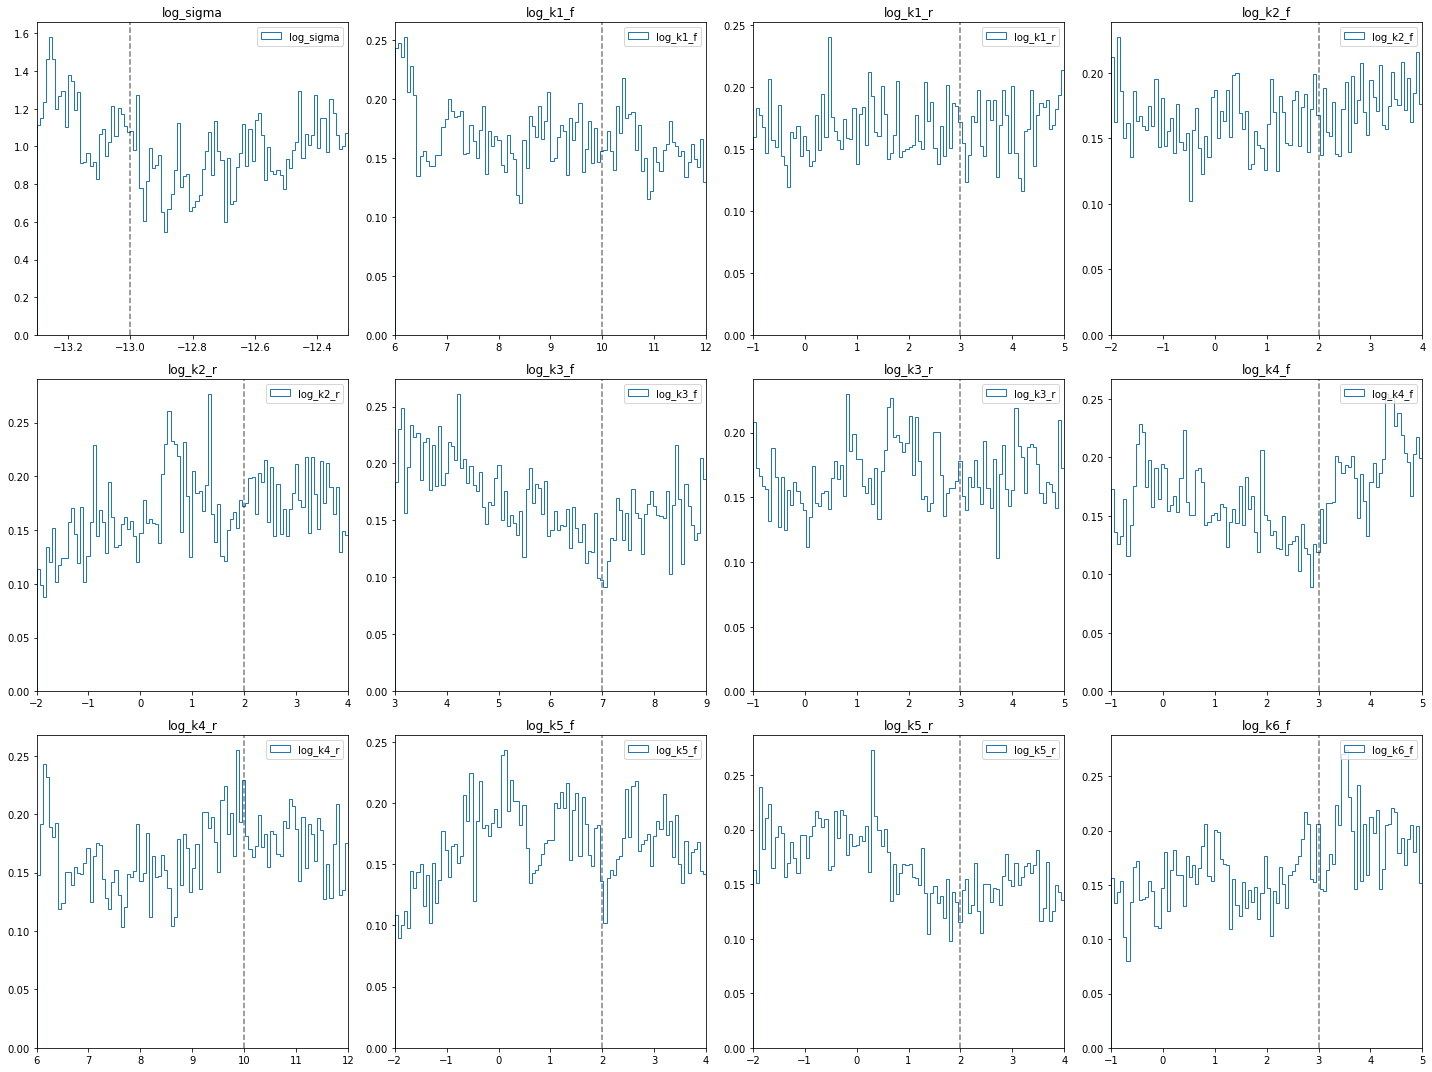

In [30]:
### 1D posterior plot
fig, ax = plt.subplots(3,4, figsize=(20,15))
axes = ax.flatten()

for i, ax_i in enumerate(axes):
    p_tmp = p_info[i]
    ax_i.set_title(f"{p_tmp[0]}")
    ax_i.axvline(p_tmp[3],ls='--', color='black', alpha=0.5)
    ax_i.set_xlim(p_tmp[1],p_tmp[2])
    

    ax_i.hist(df.iloc[:, i], 100, histtype="step", density=True, range=(p_tmp[1],p_tmp[2]), label=f'{p_tmp[0]}')
    ax_i.legend()
    
plt.tight_layout()
#plt.savefig(f'12D_transporter_AIES_PT_1D_dist_s{seed}_random.png')

NameError: name 'savefig' is not defined

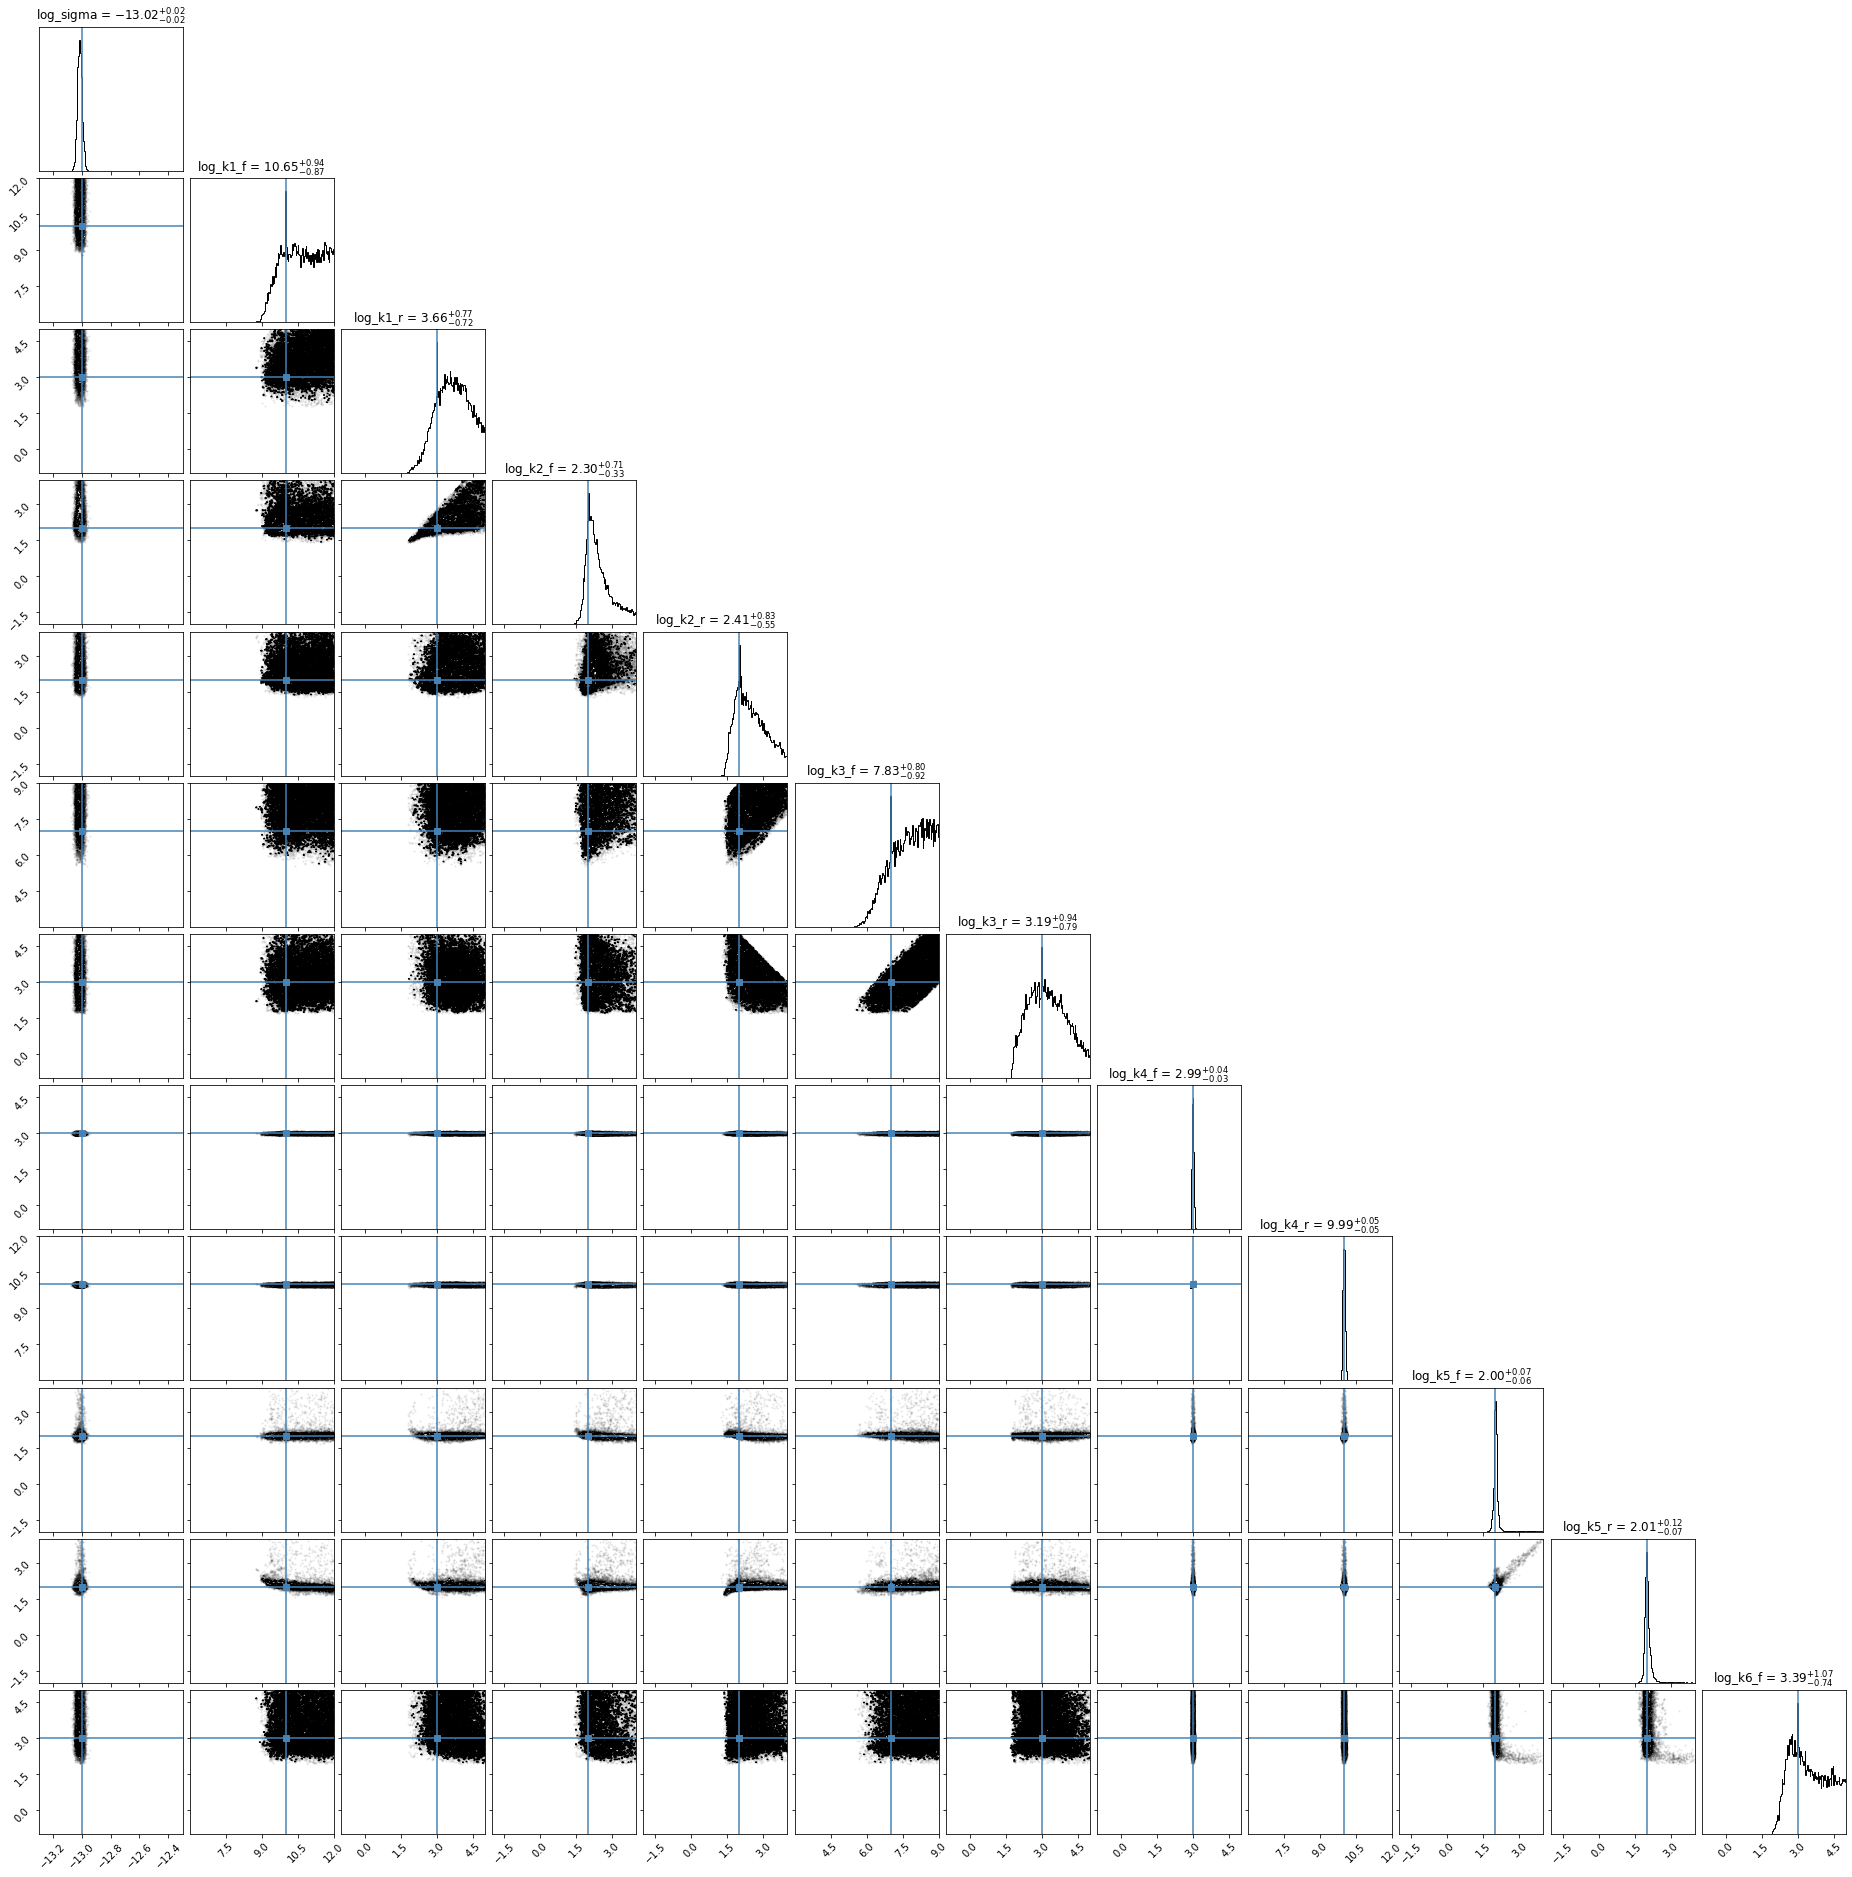

In [63]:
import pandas as pd
df = pd.read_csv("12D_transporter_AIES_PT_B1_samples_s11.csv", usecols=[i+1 for i in range(N_dim)])

import corner
p_info = [
    ["log_sigma",np.log10(5e-14), np.log10(5e-13), -13],
    ["log_k1_f",6,12,10],
    ["log_k1_r",-1,5,3],
    ["log_k2_f",-2,4,2],
    ["log_k2_r",-2,4,2],
    ["log_k3_f",3,9,7],
    ["log_k3_r",-1,5,3],
    ["log_k4_f",-1,5,3],
    ["log_k4_r",6,12,10],
    ["log_k5_f",-2,4,2],
    ["log_k5_r",-2,4,2],
    ["log_k6_f",-1,5,3],
]

ranges = [(p_info[i][1],p_info[i][2]) for i in range(len(p_info))]
truths = [p_info[i][3] for i in range(len(p_info))]
labels = [p_info[i][0] for i in range(len(p_info))]

fig = corner.corner(df, bins=200, range=ranges, truths=truths, titles=labels, show_titles=True)
savefig('12d_transporter_AIS_PT_pair_plot.png')

In [89]:


class AIS_Affine_Sampler:
    def __init__(self, ESS_min, d_beta, N_steps, K_walkers, alpha, beta_schedule, verbose):
        self.ESS_min = float(ESS_min)
        self.d_beta = float(d_beta)
        self.N_steps = int(N_steps)
        self.K_walkers = int(K_walkers)
        self.alpha = int(alpha)
        self.beta_schedule = beta_schedule
        self.verbose = verbose
        
        self.M_samples = int(self.N_steps*self.K_walkers)
        self.S_subsamples = int(self.alpha*self.K_walkers)
        
        # check if using adaptive beta schedule or fixed beta schedule
        if not self.beta_schedule:
            if self.verbose == True:
                print('> beta schedule is empty - using adaptive method')
            self.beta_adapt = True
        else:
            self.beta_adapt =False
        
        # check if hyper parameters are valid
        assert(self.M_samples > self.S_subsamples >= 10*self.K_walkers), ("invalid number of subsamples")
        assert(0.1>self.d_beta<1), ("invalid delta beta")
        
    
        

        
        

ESS_min = 10
beta_schedule = []
d_beta = 0.01
N_steps = 100
K_walkers = 10
alpha = 10
verbose = True

sampler = AIS_Affine_Sampler(ESS_min,d_beta, N_steps, K_walkers, alpha, beta_schedule, verbose)
print(vars(sampler))

> beta schedule is empty - using adaptive method
{'ESS_min': 10.0, 'd_beta': 0.01, 'N_steps': 100, 'K_walkers': 10, 'alpha': 10, 'beta_schedule': [], 'verbose': True, 'M_samples': 1000, 'S_subsamples': 100, 'beta_adapt': True}


0
0
800
(800,)
inf
0
beta new = 0.0
~ESS (sum of relative probability) = 800.0 samples
beta new = 0.01
~ESS (sum of relative probability) = 731.8078362168101 samples
beta new = 0.02
~ESS (sum of relative probability) = 675.8462508046157 samples
beta new = 0.03
~ESS (sum of relative probability) = 629.0882127038815 samples
beta new = 0.04
~ESS (sum of relative probability) = 589.386033890639 samples
beta new = 0.05
~ESS (sum of relative probability) = 555.1933385292364 samples
beta new = 0.06
~ESS (sum of relative probability) = 525.3792041319566 samples
beta new = 0.07
~ESS (sum of relative probability) = 499.1030383609275 samples
beta new = 0.08
~ESS (sum of relative probability) = 475.72967552483766 samples
beta new = 0.09
~ESS (sum of relative probability) = 454.7712548300728 samples
beta new = 0.1
~ESS (sum of relative probability) = 435.8470429620604 samples
beta new = 0.11
~ESS (sum of relative probability) = 418.655363017786 samples
beta new = 0.12
~ESS (sum of relative probabil

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_17323/169498925.py:19: RuntimeWarning: divide by zero encountered in log
  return np.where(x != 0, np.log(x), -np.inf)


800
(100, 1)


/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_17323/169498925.py:19: RuntimeWarning: divide by zero encountered in log
  return np.where(x != 0, np.log(x), -np.inf)


1
0.21
800
(800, 1)
inf
0
beta new = 0.21
~ESS (sum of relative probability) = 800.0 samples
beta new = 0.22
~ESS (sum of relative probability) = 778.3171343867883 samples
beta new = 0.22999999999999998
~ESS (sum of relative probability) = 757.7880659699815 samples
beta new = 0.24
~ESS (sum of relative probability) = 738.3211253046951 samples
beta new = 0.25
~ESS (sum of relative probability) = 719.8338842307792 samples
beta new = 0.26
~ESS (sum of relative probability) = 702.2520760376352 samples
beta new = 0.27
~ESS (sum of relative probability) = 685.5086548971165 samples
beta new = 0.28
~ESS (sum of relative probability) = 669.5429752812445 samples
beta new = 0.29
~ESS (sum of relative probability) = 654.3000748984023 samples
beta new = 0.3
~ESS (sum of relative probability) = 639.7300470697538 samples
beta new = 0.31
~ESS (sum of relative probability) = 625.787490494313 samples
beta new = 0.32
~ESS (sum of relative probability) = 612.4310260728435 samples
beta new = 0.329999999999

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_17323/169498925.py:19: RuntimeWarning: divide by zero encountered in log
  return np.where(x != 0, np.log(x), -np.inf)


800
(100, 1)


/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_17323/169498925.py:19: RuntimeWarning: divide by zero encountered in log
  return np.where(x != 0, np.log(x), -np.inf)


2
0.78
800
(800, 1)
inf
0
beta new = 0.78
~ESS (sum of relative probability) = 800.0 samples
beta new = 0.79
~ESS (sum of relative probability) = 794.4755927325014 samples
beta new = 0.8
~ESS (sum of relative probability) = 789.0452017631085 samples
beta new = 0.81
~ESS (sum of relative probability) = 783.7064743363511 samples
beta new = 0.8200000000000001
~ESS (sum of relative probability) = 778.4571298040837 samples
beta new = 0.8300000000000001
~ESS (sum of relative probability) = 773.2949571446258 samples
beta new = 0.8400000000000001
~ESS (sum of relative probability) = 768.217812573365 samples
beta new = 0.8500000000000001
~ESS (sum of relative probability) = 763.2236172413055 samples
beta new = 0.86
~ESS (sum of relative probability) = 758.3103550181773 samples
beta new = 0.87
~ESS (sum of relative probability) = 753.4760703568629 samples
beta new = 0.88
~ESS (sum of relative probability) = 748.7188662360165 samples
beta new = 0.89
~ESS (sum of relative probability) = 744.036902

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_17323/169498925.py:19: RuntimeWarning: divide by zero encountered in log
  return np.where(x != 0, np.log(x), -np.inf)


800
(100, 1)


/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_17323/169498925.py:19: RuntimeWarning: divide by zero encountered in log
  return np.where(x != 0, np.log(x), -np.inf)


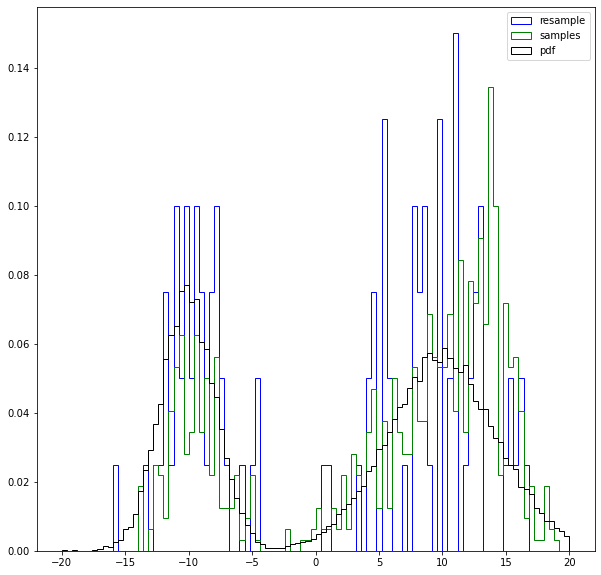

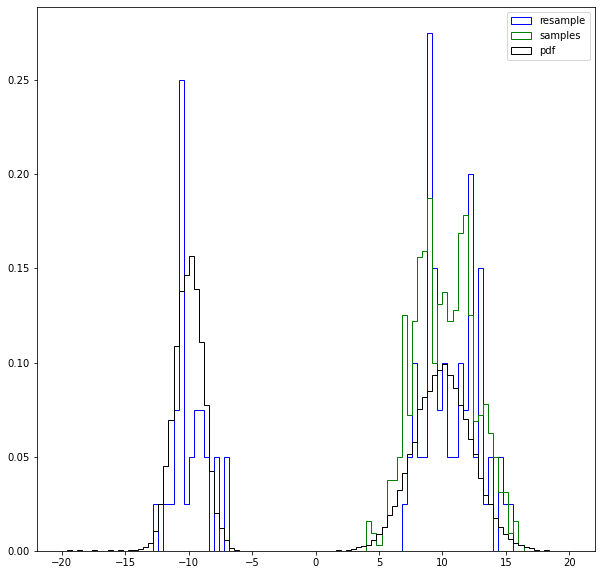

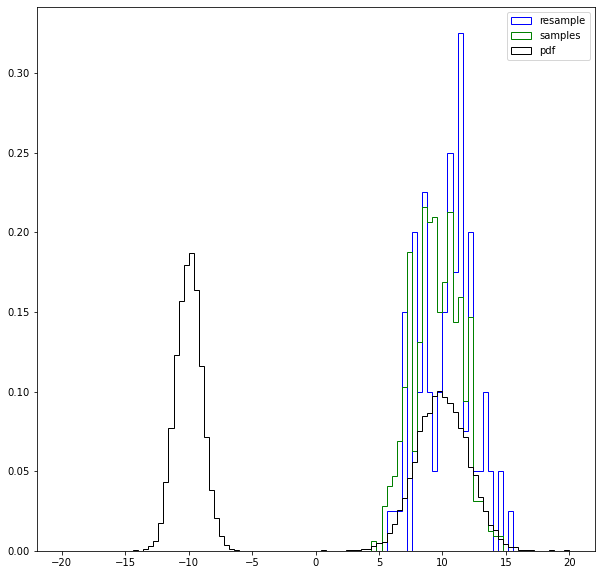

In [17]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import emcee
import matplotlib.pyplot as plt


def prior(x):
    if np.all(x>=-20) and np.all(x<=20):
        return np.ones(np.size(x))
    else:
        return np.zeros(np.size(x))
        
def likelihood(x, mu, sigma):
    L = 0.5*(1/(sigma[0] * np.sqrt(2 * np.pi))*np.exp(-(x-mu[0])**2 / (2 * sigma[0]**2))) + 0.5*(1/(sigma[1] * np.sqrt(2 * np.pi))*np.exp(-(x-mu[1])**2 / (2 * sigma[1]**2)))
    return L

def log_inf(x):
    return np.where(x != 0, np.log(x), -np.inf) 


### bimodal Gaussian in 1D
def log_prob(x, beta, mu, sigma):
    pr_x = prior(x) 
    like_x = likelihood(x, mu, sigma)
    log_pr = log_inf(pr_x)
    log_like = log_inf(like_x)  
    return log_pr + beta*log_like


### analytical model
def prob(x,beta, mu, sigma):
    pr = 1.0
    L = 0.5*(1/(sigma[0] * np.sqrt(2 * np.pi))*np.exp(-(x-mu[0])**2 / (2 * sigma[0]**2))) + 0.5*(1/(sigma[1] * np.sqrt(2 * np.pi))*np.exp(-(x-mu[1])**2 / (2 * sigma[1]**2)))
    
    p = pr*(L**beta)
    bin_width = np.size(x)/np.ptp(x)
    p_sum = np.array([])
    
    return (pr*(L**beta))

### model configuration
mu = [-10,10]
sigma = [1,2]
x = np.linspace(-20,20,100)
beta = [0, 0.1, 1]
#y_beta = [np.exp(log_prob(x, b, mu, sigma)) for b in beta]  # problem here


### sampling settings
np.random.seed(10)
max_iter = 100
ESS_min = 300
beta_schedule = [0, 0.1, 1]
d_beta = 0.01
N_steps = 1000
K_walkers = 100
burn_in = 500
alpha = 800
dim = 1
beta=0


### step 1: initialization
S = (np.ptp(x)*np.random.rand(alpha))-np.max(x)  
j = 0

while (beta< 1) and (j < max_iter):
    print(j)
    print(beta)
    print(np.size(S))
    
    assert(np.size(S)==alpha)
    print(np.shape(S))
    S = S.flatten()
    ESS = np.inf
    log_p1 = log_prob(S,beta,mu, sigma)
    i = 0
    beta_tmp_list = []
    log_p2_tmp_list = []
    w_rel_tmp_list = []
    ESS_tmp_list = []
    print(ESS)
    print(i)
    beta_new = beta
    while (beta_new <= 1) and (ESS > ESS_min) and (i < max_iter):
        beta_new = beta+d_beta*i
        log_p2 = log_prob(S,beta_new,mu, sigma)
        log_w = log_p2 - log_p1
        log_w_rel = log_w-np.max(log_w)
        w_rel = np.exp(log_w_rel)
        p_rel = w_rel/np.sum(w_rel)
        ESS = np.sum(w_rel)


        beta_tmp_list.append(beta_new)
        log_p2_tmp_list.append(log_p2)
        w_rel_tmp_list.append(p_rel)
        ESS_tmp_list.append(ESS)
        print(f'beta new = {beta_new}')
        print(f'~ESS (sum of relative probability) = {ESS} samples')
        i += 1


    beta=beta_tmp_list[-2]
    rel_w_list = w_rel_tmp_list[-2]

    re_S = np.random.choice(S,size=K_walkers,p=rel_w_list)

    plt.figure(figsize=(10,10))
    #plt.hist(rel_w_list, 100, range=(-20,20), color="k", histtype="step", density=True, label='rel w')
    plt.hist(re_S, 100, range=(-20,20), color="blue", histtype="step", density=True, label='resample')

    start_pos = np.array([[s] for s in re_S])
    print(np.shape(start_pos))

    sampler = emcee.EnsembleSampler(K_walkers, dim, log_prob, args=[beta, mu, sigma])
    state = sampler.run_mcmc(start_pos, N_steps)
    S = sampler.flatchain[-alpha:]
    print(np.size(S))
 
    plt.hist(S, 100, range=(-20,20), color="green", histtype="step", density=True, label='samples')


    p0 = (np.ptp(x)*np.random.rand(K_walkers, dim))-np.max(x)
    print(np.shape(p0))

    sampler = emcee.EnsembleSampler(K_walkers, dim, log_prob, args=[beta, mu, sigma])
    state = sampler.run_mcmc(p0, N_steps)
    samples = sampler.flatchain[burn_in:]

    plt.hist(samples, 100, range=(-20,20), color="k", histtype="step", density=True, label='pdf')
    plt.legend()
    j += 1
    

